# Tracking Evaluation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](ここに以下の書式でURLを入れる) 
[![github](https://badgen.net/badge/:status/View%20On%20Github/black?icon=github&label)](https://github.com/AtomScott/SoccerTrack)
[![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=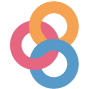)](https://)

---

This is a work in progress tutorial, more to come soon!

In [1]:
%load_ext autoreload
%autoreload 2

Multi-Object Tracking (MOT) is notoriously difficult to evaluate accurately. While commonly used metrics such as MOTA tend to overemphasize accurate detection, IDF1 and AssA tend to overemphasize association quality. Consequently, since its proposal, Higher-Order Tracking Accuracy (HOTA) has been adopted as the primary metric in several recent benchmarks (BDD100K, KITTI, DanceTrack). HOTA seeks to balance detection and association by combining a DetA and an AssA.

In [2]:
import soccertrack
from soccertrack import Camera

dataset_path = soccertrack.datasets.get_path('top-view')
path_to_csv = sorted(dataset_path.glob('annotations/*.csv'))[0]

bbdf = soccertrack.load_df(path_to_csv) # We will use this as ground truth
bbdf_gt = bbdf
bbdf_track = bbdf

## MOTA

**Multiple Object Tracking Accuracy (MOTA)** is a measure of the overall accuracy of the tracker. This metric has been widely adopted in the literature and considers three types of errors: (1) missed detections, (2) false positives, and (3) identity switches. The MOTA score is calculated as the sum of these three types of errors, normalized by the total number of ground truth objects. A higher MOTA score indicates a better performance of the tracker.

\begin{equation*}
    MOTA = 1 - \frac{ \sum_{t} (m_t + fp_t + mme_t)}{\sum_{{ }_t} {g_t}} 
\end{equation*}

$m_t$:  The number of misses at time $t$
$fp_t$:  The number of false positives
$mme_t$:  The number of identity switches
$g_t$: The number of objects present at time $t$

$MOTA$ has several limitations. For example, it overemphasizes the importance of accurate object detection, and does not take into account the association of objects over time. While the maximum possible $MOTA$ score is 1, there is no fixed minimum value. 


To use MOTA in your own code, you can use `soccertrack.metrics.mota_score()`.

The following values are calculated and reported by `soccertrack.metrics.mota_score()`:

* **Multiple Object Tracking Precision (MOTP)** is a measure of the precision of the tracker in terms of the location of the tracked objects. It is calculated as the average distance between the predicted and ground truth object locations. A higher MOTP score indicates better performance.

* **Most Tracked Objects (MT)** is the number of ground truth objects that are successfully tracked for at least 50% of the frames in which they appear. This metric gives an indication of how well the tracker is able to maintain object tracks.

* **Most Lost Objects (ML)** is the number of ground truth objects that are not successfully tracked for at least 50% of the frames in which they appear. This metric gives an indication of how well the tracker is able to maintain object tracks.

* **Fragmentation** is a measure of how many times the tracker switches between different ground truth objects. A higher fragmentation score indicates worse performance.

* **Id-Switches** is the number of times the tracker switches the identity of a ground truth object with another ground truth object. This metric gives an indication of how well the tracker is able to maintain object identities.

In [3]:
from soccertrack.metrics import mota_score

mota = mota_score(bbdf_gt, bbdf_track)
print(mota)

Preprocessing for MOT evaluation: 100%|██████████| 900/900 [00:24<00:00, 36.13it/s]


{'MOTA': 1.0, 'MOTP': 1.0, 'MODA': 1.0, 'CLR_Re': 1.0, 'CLR_Pr': 1.0, 'MTR': 1.0, 'PTR': 0.0, 'MLR': 0.0, 'sMOTA': 1.0, 'CLR_F1': 1.0, 'FP_per_frame': 0.0, 'MOTAL': 1.0, 'MOTP_sum': 20700.0, 'CLR_TP': 20700, 'CLR_FN': 0, 'CLR_FP': 0, 'IDSW': 0, 'MT': 23, 'PT': 0, 'ML': 0, 'Frag': 0.0, 'CLR_Frames': 900}


## HOTA

Higher-Order Tracking Accuracy (HOTA) is a metric that seeks to balance detection and association quality. It is calculated as the product of the Detection Accuracy (DetA) and the Association Accuracy (AssA). The DetA is calculated as the average of the detection accuracy for each class. The AssA is calculated as the average of the association accuracy for each class. The HOTA score is calculated as the product of the DetA and the AssA. A higher HOTA score indicates a better performance of the tracker.


\begin{equation*}
HOTA_\alpha = \sqrt{\frac{\sum_{c\in\{TP\}} \textit{A}(c)}{\lvert TP \rvert + \lvert FN \rvert + \lvert FP \rvert}}
\end{equation*}

\begin{equation*}
A(c) = \frac{\lvert TPA(c) \rvert}{\lvert TPA(c) \rvert + \lvert FNA(c) \rvert + \lvert FPA(c) \rvert}
\end{equation*}
$A(c):$ Measures how similar predicted trajectory and ground-truth trajectory are.  \\
$TP:$ True Positive. A ground truth detection and predicted detection are matched together given that $S \geq \alpha$. $S$ is the localization similarity and  $\alpha$ is the threshold.\\
$FN:$ False Negative. A ground truth detection that was missed\\
$FP:$ False Positive. A predicted detection with no respective ground truth detection.\\
$TPA:$ True Positive Association. The set of True Positives that have the same ground truth IDs and the same prediction ID as a given $TP c$.
\begin{align*}
    TPA&(c) = \{k\}, \\
    &k \in \{TP|prID(k) = prID(c) \wedge gtID(c) = gtID(c)\}
\end{align*}
$FNA:$ The set of ground truth detections with the same ground truth ID as a given $TP c$. However, these detections were assigned a prediction ID different from $c$ or none at all.
\begin{align*}
    FNA&(c) = \{k\}, \\
    k & \left. \in
    \begin{aligned}
       & \{TP \,|\, prID(k) \ne prID(c) \wedge gtID(k) =  gtID(c)\} \\
       & \cup \{FN \,|\, gtID(k) = gtID(c)\} 
    \end{aligned}
    \right.
\end{align*}
$FPA:$ The set of predicted detections with the same prediction ID as a given $TP c$. However, these detections were assigned a ground-truth  ID different from $c$ or none at all.
\begin{align*}
    FPA&(c) = \{k\}, \\
    k & \left. \in
    \begin{aligned}
       & \{TP \,|\,prID(k) = prID(c)\wedge gtID(k) \neq gtID(c)\} \\
       & \cup \{FP \,|\, prID(k) = prID(c)\} 
    \end{aligned}
    \right.
\end{align*}

The $HOTA_\alpha$ score represents the value of $HOTA$ calculated for a specific value of $\alpha$. In order to obtain the final $HOTA$ score, it is necessary to calculate $HOTA_\alpha$ for a range of values of $\alpha$ from 0 to 1 and then take the average of these values. This allows for a more thorough evaluation of the performance of multiple object tracking systems using the $HOTA$ metric.

\begin{align*}
 HOTA =  \int_{0}^{1} HOTA\alpha \:d\alpha \approx \frac{1}{19} \sum_{\alpha \in \left \{
 \begin{aligned}
     & 0.05, 0.1,\\
     & ...0.9,0.95
 \end{aligned} \right \} } HOTA\alpha
\end{align*}

To use HOTA in your own code, you can use `soccertrack.metrics.hota_score()`.

In [4]:
from soccertrack.metrics import hota_score

hota = hota_score(bbdf_gt, bbdf_track)
print(hota)

Preprocessing for MOT evaluation: 100%|██████████| 900/900 [00:23<00:00, 37.58it/s]


{'HOTA': 1.0, 'DetA': 1.0, 'AssA': 1.0, 'DetRe': 1.0, 'DetPr': 1.0, 'AssRe': 1.0, 'AssPr': 1.0, 'LocA': 1.0, 'RHOTA': 1.0, 'HOTA_TP': 20700.0, 'HOTA_FN': 0.0, 'HOTA_FP': 0.0, 'HOTA(0)': 1.0, 'LocA(0)': 1.0, 'HOTALocA(0)': 1.0}


## AssA

The Association Accuracy score reflects the average alignment between matching trajectories and focuses on association errors, which occur when a single object in the ground truth is assigned two different predicted detections or a single predicted detection is assigned to two different ground truth objects. According to the MOT Benchmark, the Association Accuracy score is calculated as the average of the association Jaccard index over all matching detections and is then averaged over the localization threshold\cite{luiten2021hota}.

\begin{equation*}
AssA\alpha = \frac{1}{\lvert TP \rvert} \sum_{c\in\{TP\}} A(c)
\end{equation*}

In [5]:
# AssA is calculated within hota_score
print(hota['AssA'])

1.0


## DetA
Detection Accuracy is a measure of the performance of multiple object tracking systems that evaluates the accuracy of object detection. According to the MOT Benchmark, the Detection Accuracy score is calculated as the Detection Jaccard Index averaged over the localization threshold\cite{luiten2021hota}.


\begin{equation*}
DetA_\alpha = \frac{\lvert TP \rvert}{\lvert TP \rvert + \lvert FN \rvert+ \lvert FP \rvert}
\end{equation*}

In [6]:
# DetA is calculated within hota_score
print(hota['DetA'])

1.0


## IDF1
The Identification Metric differs from others, such as $MOTA$, in that it focuses on mapping predicted trajectories with actual trajectories rather than performing bijective mapping at the detection level. Some researchers prefer this approach due to its emphasis on association over detection accuracy \cite{luiten2021hota}.

\begin{equation*}
    ID-Recall = \frac{\lvert IDTP \rvert }{\lvert IDTP \rvert + \lvert IDFN \rvert }
\end{equation*}
\begin{equation*}
    ID-Precision = \frac{\lvert IDTP \rvert }{\lvert IDTP \rvert + \lvert IDFP \rvert } 
\end{equation*}
\begin{equation*}
    IDF1 = \frac{\lvert IDTP \rvert }{\lvert IDTP \rvert +0.5\lvert IDFP \rvert + 0.5\lvert IDFN \rvert }
\end{equation*}

$IDTP$: Identity True Positive. The predicted object trajectory and ground truth object trajectory match.\\
$IDFN$: Identify False Negative. Any ground truth detection that went undetected and has an unmatched trajectory.\\
$IDFP$: Identity False Positive. Any predicted detection that is false.

$IDF1$ metric is not without its flaws. The best unique bijective mapping may not necessarily result in the best alignment between predicted and actual trajectories. This can lead to a decrease in the $IDF1$ score even in the presence of correct detections. Additionally, many unmatched trajectories can also lead to decreased scores. This can incentivize researchers to prioritize increasing the number of unique detections over making accurate associations.


To use IDF1 in your own code, you can use `soccertrack.metrics.idf1_score()`.

In [7]:
from soccertrack.metrics import identity_score

identity = identity_score(bbdf_gt, bbdf_track)
print(identity)

Preprocessing for MOT evaluation: 100%|██████████| 900/900 [00:24<00:00, 36.20it/s]


{'IDF1': 1.0, 'IDR': 1.0, 'IDP': 1.0, 'IDTP': 20700, 'IDFN': 0, 'IDFP': 0}
